In [38]:
%matplotlib inline
from re import DEBUG
from turtle import color
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from warnings import simplefilter
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import WindowsPath
import time
from collections import defaultdict
import re
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import datetime
import pickle
from collections import Counter

DEBUGGING: bool = False
NUM_EVENT_PER_POS = 100
MAP_SET_PADS_TO_TRIANGLE = defaultdict(
    int,
    {
        frozenset([6, 5, 4]): 1,
        frozenset([4, 5, 3]): 2,
        frozenset([4, 3, 2]): 3,
        frozenset([3, 2, 1]): 4,
        frozenset([6, 8, 5]): 5,
        frozenset([5, 3, 13]): 6,
        frozenset([3, 13, 1]): 7,
        frozenset([8, 5, 10]): 8,
        frozenset([5, 10, 13]): 9,
        frozenset([13, 1, 14]): 10,
        frozenset([8, 9, 10]): 11,
        frozenset([10, 11, 13]): 12,
        frozenset([11, 13, 14]): 13,
        frozenset([9, 10, 11]): 14,
    },
)
max_num_triangle: int = 14
COL_PADS = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14])
UNIT_OF_MEASURE_COL = {
    "pmax": "mV",
    "negpmax": "mV",
    "tmax": "ns",
    "area": "mV $\\cdot$ ns",
    "rms": "mV",
}


In [14]:
dev_df_proc = pd.read_csv("./development_processed.csv", header=0, index_col=False)
eval_df_processed = pd.read_csv("./evaluation_processed.csv", header = 0, index_col = False)
eval_df_processed.drop(["triangle", "x_triag", "y_triag"], inplace=True, axis = 1)
dev_df_proc["maxpmax"] = dev_df_proc[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)
eval_df_processed["maxpmax"] = eval_df_processed[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)

for pad in COL_PADS:
    dev_df_proc[f"nomr_pmax[{pad}]"]=dev_df_proc[f"pmax[{pad}]"]/dev_df_proc["maxpmax"]
    eval_df_processed[f"nomr_pmax[{pad}]"]=eval_df_processed[f"pmax[{pad}]"]/eval_df_processed["maxpmax"]

In [15]:
dev_df_proc

,x,y,negpmax[1],pmax[1],area[1],negpmax[2],pmax[2],area[2],negpmax[3],pmax[3],...,nomr_pmax[3],nomr_pmax[4],nomr_pmax[5],nomr_pmax[6],nomr_pmax[8],nomr_pmax[9],nomr_pmax[10],nomr_pmax[11],nomr_pmax[13],nomr_pmax[14]
0,200.0,200.0,-17.721210,5.409161,4.538778,-19.892543,6.084506,3.132328,-23.747293,3.811328,...,0.025468,0.032697,0.062295,0.020564,0.177624,0.663963,0.281114,0.083118,0.049816,0.044183
1,200.0,200.0,-4.736827,4.414289,3.720435,-3.787175,4.507257,3.267461,-5.427002,3.940369,...,0.026456,0.037258,0.062936,0.036419,0.186629,0.644962,0.259765,0.082758,0.124024,0.092668
2,200.0,200.0,-5.985437,4.567191,3.490490,-3.948853,5.384155,2.929150,-4.559235,4.903412,...,0.031945,0.024727,0.048861,0.038088,0.150909,0.610884,0.262791,0.060284,0.047798,0.038699
3,200.0,200.0,-4.229949,5.019058,6.786200,-5.576041,4.165598,1.544370,-4.981216,3.791672,...,0.024968,0.031929,0.068631,0.033965,0.175115,0.590152,0.248892,0.071782,0.055648,0.042374
4,200.0,200.0,-5.783587,3.250262,2.449456,-5.137939,4.736023,4.211047,-4.447104,5.123048,...,0.037357,0.022070,0.091570,0.044590,0.184205,0.773736,0.307731,0.101770,0.063599,0.032690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385495,600.0,595.0,-26.266623,49.819376,24.781403,-29.947864,55.651440,28.621582,-36.910852,63.119604,...,0.478953,0.090624,0.097720,0.034938,0.035427,0.025227,0.038081,0.041937,0.147618,0.044334
385496,600.0,595.0,-26.138474,51.016495,27.090894,-34.662131,58.084024,28.435582,-37.721255,59.971158,...,0.491563,0.094714,0.079749,0.033406,0.115588,0.105081,0.099183,0.124659,0.144299,0.096877
385497,600.0,595.0,-30.943115,46.661682,24.980347,-35.670273,61.840103,30.500351,-38.344370,73.850089,...,0.560081,0.128055,0.099381,0.048400,0.054307,0.029274,0.049959,0.040524,0.157623,0.076755
385498,600.0,595.0,-22.520367,46.515765,33.163073,-33.298181,49.772070,27.110076,-36.103391,59.277927,...,0.483279,0.099396,0.090814,0.119086,0.134339,0.092821,0.107738,0.110919,0.114532,0.087682


In [16]:
eval_df_processed

,negpmax[1],pmax[1],area[1],negpmax[2],pmax[2],area[2],negpmax[3],pmax[3],area[3],negpmax[4],...,nomr_pmax[3],nomr_pmax[4],nomr_pmax[5],nomr_pmax[6],nomr_pmax[8],nomr_pmax[9],nomr_pmax[10],nomr_pmax[11],nomr_pmax[13],nomr_pmax[14]
0,-3.598874,8.738040,5.554105,-4.603192,5.359271,3.547230,-4.175235,11.347125,9.340524,-3.853809,...,0.145805,0.084518,0.177460,0.074619,0.052198,0.072470,0.278617,0.371556,0.788201,0.228755
1,-20.616669,23.460358,17.998419,-20.351328,20.116995,11.315171,-57.040155,95.746893,47.867699,-9.163229,...,0.797330,0.075915,0.125071,0.041978,0.039900,0.040383,0.037647,0.031168,0.196425,0.085545
2,-7.224267,4.837952,3.289124,-4.086172,6.132150,3.578799,-5.478476,7.510110,5.374246,-6.361444,...,0.069931,0.080630,0.374289,0.236871,0.909571,0.194017,0.368056,0.078968,0.120438,0.033119
3,-45.786813,87.293692,38.422989,-14.530936,25.325571,10.306552,-32.861496,63.661270,33.719995,-5.858838,...,0.552824,0.089263,0.124345,0.044853,0.043777,0.045979,0.079366,0.058708,0.380860,0.141159
4,-5.374179,9.593125,7.767408,-4.427225,6.618451,3.765579,-6.082755,13.074960,7.939478,-5.505234,...,0.134716,0.088962,0.506533,0.096738,0.246472,0.100402,0.951973,0.215293,0.564634,0.105064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128495,-3.704605,9.327438,6.657654,-4.856036,4.763165,11.514778,-3.541619,7.936588,7.715925,-3.915192,...,0.066377,0.035406,0.155704,0.050519,0.064206,0.087332,0.465537,0.588112,0.454562,0.187619
128496,-6.185739,5.833882,4.184656,-5.154848,3.790421,4.475711,-3.697132,4.913111,3.358511,-6.445482,...,0.041891,0.044427,0.126519,0.048456,0.192894,0.364582,0.802632,0.184406,0.128665,0.038088
128497,-8.160696,19.402353,11.304202,-8.818259,17.555460,9.256798,-70.797495,115.297141,52.297519,-15.535886,...,1.000000,0.273497,0.269611,0.104177,0.036608,0.033358,0.060368,0.045998,0.203981,0.042509
128498,-5.312485,4.200095,2.652198,-4.739268,2.959903,0.946364,-3.379894,8.768869,5.850084,-4.523834,...,0.077665,0.075821,0.376915,0.172470,0.740789,0.172314,0.464520,0.096494,0.130661,0.100635


In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    dev_df_proc.drop(["x", "y"], axis=1), dev_df_proc[["x", "y"]], train_size=0.8, shuffle=True
)

start_time = datetime.datetime.now().replace(microsecond=0)
regr = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None, n_jobs=-1)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

4.166193115714044
Time for the computations:
0:10:02


          feature  importance
43   norm_pmax[8]    0.078266
19        pmax[8]    0.071524
40   norm_pmax[4]    0.060655
37   norm_pmax[1]    0.060563
1         pmax[1]    0.054636
48  norm_pmax[14]    0.036169
46  norm_pmax[11]    0.035812
7         pmax[3]    0.034699
25       pmax[10]    0.033723
45  norm_pmax[10]    0.033610
34       pmax[14]    0.030730
39   norm_pmax[3]    0.030112
42   norm_pmax[6]    0.028750
28       pmax[11]    0.028553
41   norm_pmax[5]    0.028495
16        pmax[6]    0.026323
18     negpmax[8]    0.023937
10        pmax[4]    0.023121
12     negpmax[5]    0.021391
29       area[11]    0.019536
24    negpmax[10]    0.019200
47  norm_pmax[13]    0.018380
13        pmax[5]    0.017514
27    negpmax[11]    0.017390
31       pmax[13]    0.016650
6      negpmax[3]    0.015802
22        pmax[9]    0.014759
44   norm_pmax[9]    0.013533
26       area[10]    0.011795
20        area[8]    0.009069
30    negpmax[13]    0.008218
33    negpmax[14]    0.007740
8         

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 640x480 with 0 Axes>

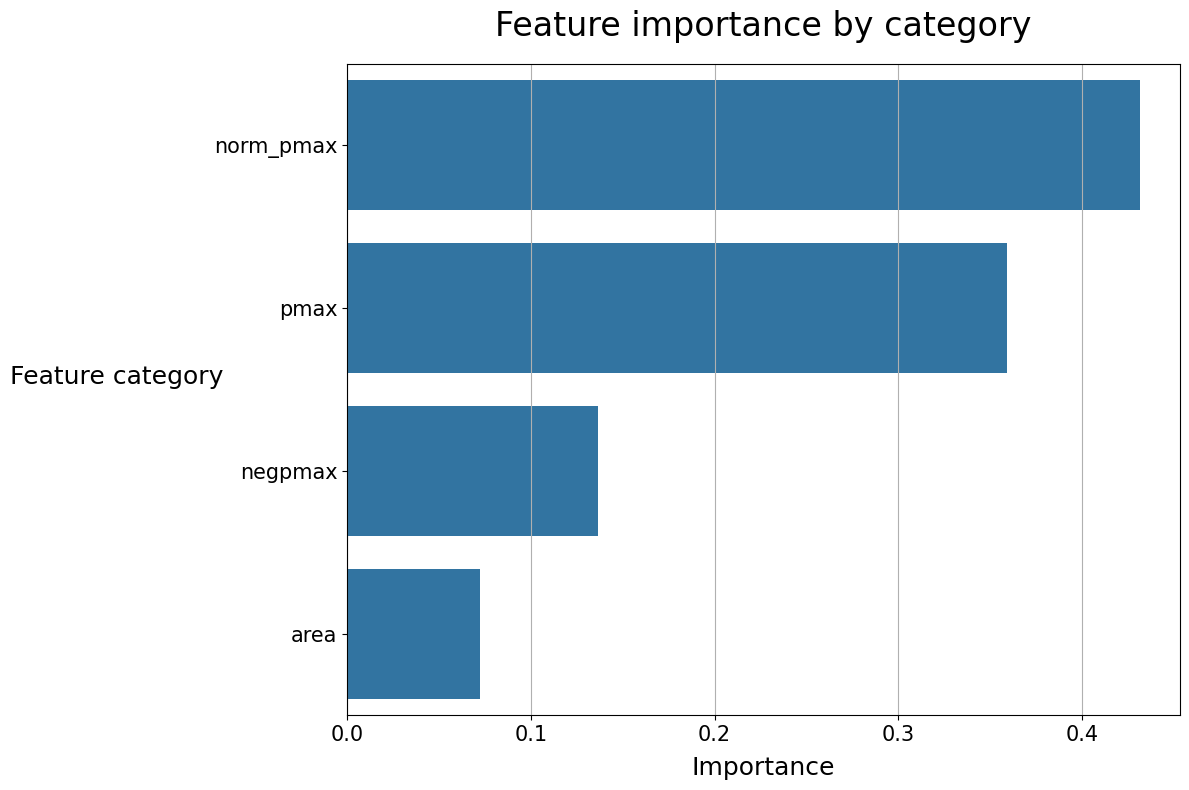

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 640x480 with 0 Axes>

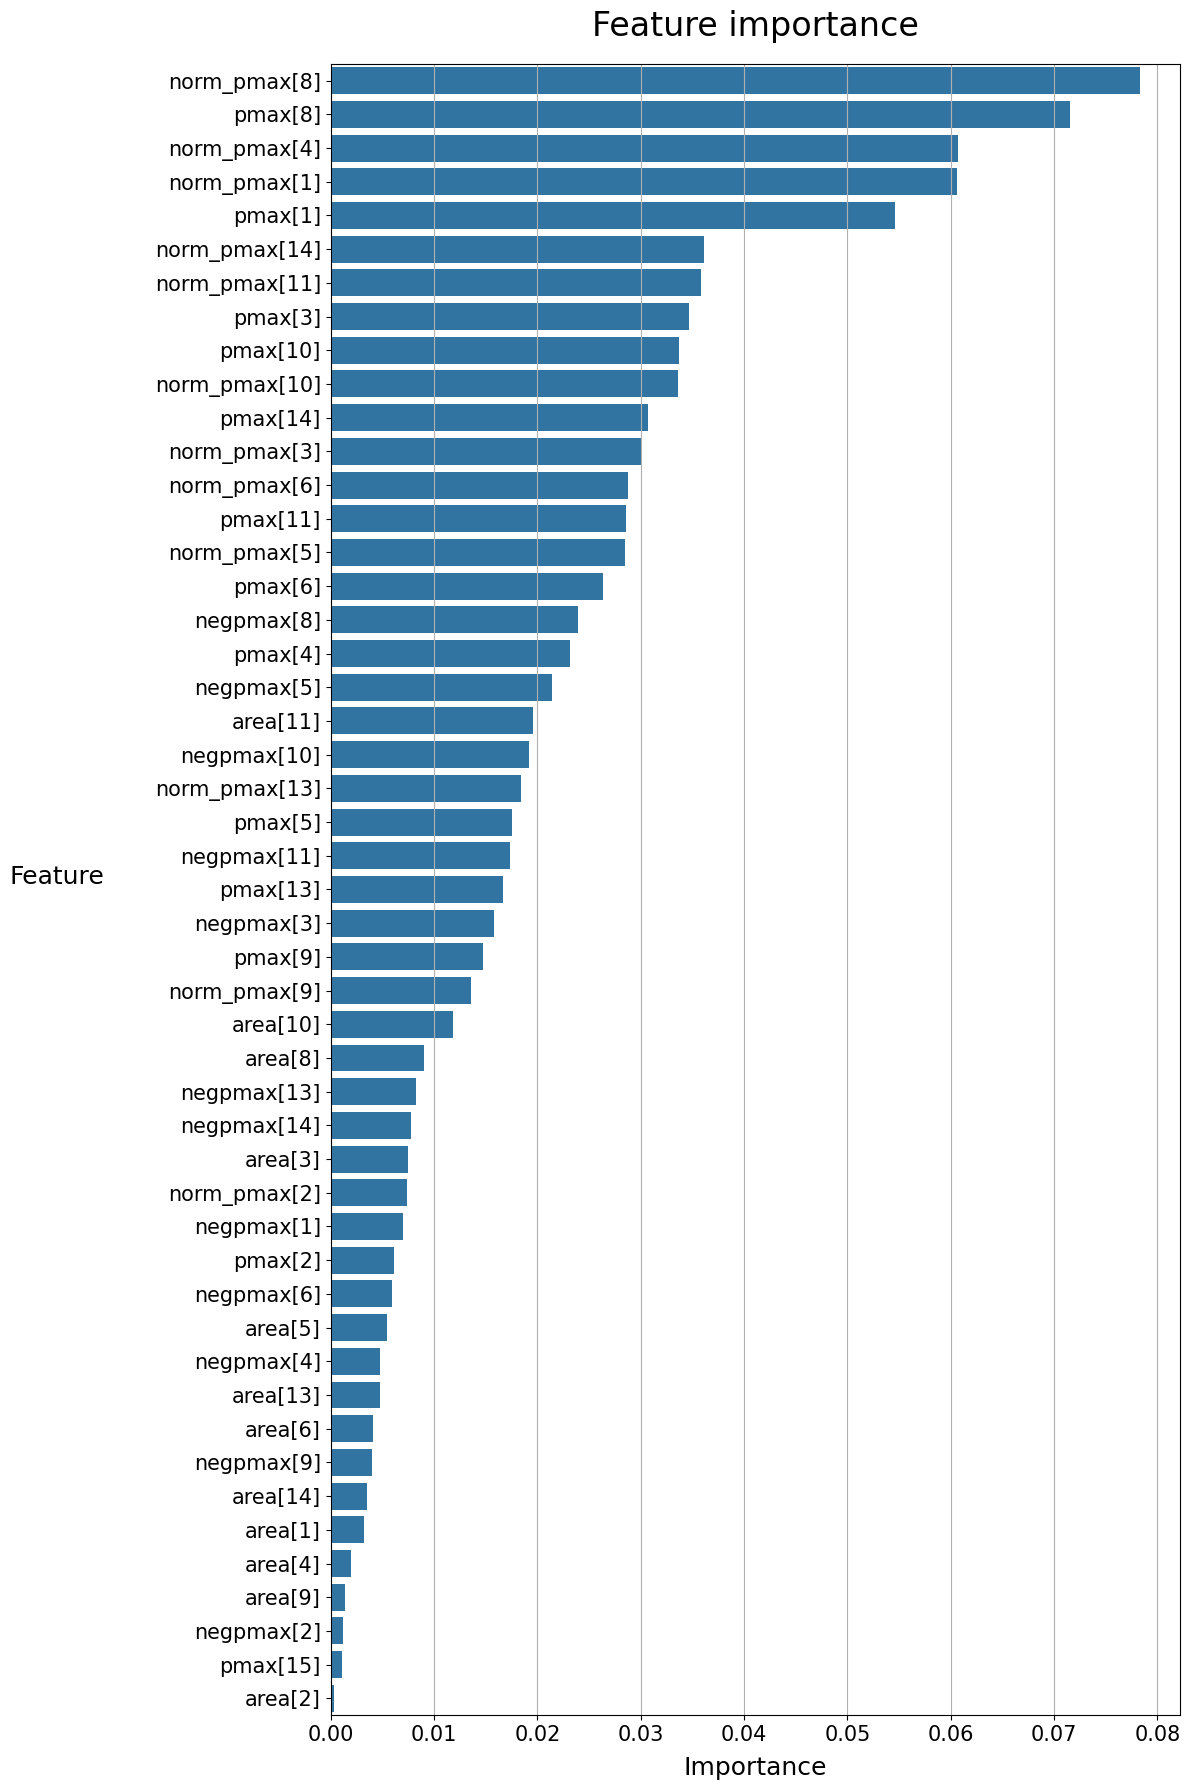

In [23]:
def analyse_feature_importante(
    forest: RandomForestRegressor, features_names: list[str]
):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    feature_import_df = pd.DataFrame(
        {
            "feature": features_names,
            "importance": importances,
        }
    )
    feature_import_df = feature_import_df.sort_values("importance", ascending=False)
    print(feature_import_df)

    # groupying by type of feature
    feature_cat_import_df = pd.DataFrame(
        {
            "feature": [re.sub(r"\[\d+\]", "", feat) for feat in features_names],
            "importance": importances,
        }
    )
    feature_cat_import_df = (
        feature_cat_import_df.groupby("feature", as_index=False)
        .sum()
        .sort_values("importance", ascending=False)
    )
    print(feature_cat_import_df)
    feature_import_df["std"] = std
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    plot = sns.barplot(
        feature_cat_import_df,
        y="feature",
        x="importance",
        color=sns.color_palette()[0],
        ax=ax,
    )
    personalize_barplot(
        ax,
        fig,
        feature_cat_import_df,
        "Feature importance by category",
        "Importance",
        "Feature category",
    )
    plt.show()
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    plot = sns.barplot(
        feature_import_df,
        y="feature",
        x="importance",
        color=sns.color_palette()[0],
        ax=ax,
    )
    personalize_barplot(
        ax,
        fig,
        feature_import_df,
        "Feature importance",
        "Importance",
        "Feature",
        12,
        18,
    )
    plt.show()



def personalize_barplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(
        axis="x",
        labelsize=15,
    )
    ax.tick_params(
        axis="y",
        labelsize=15,
    )
    plt.tight_layout()


    

analyse_feature_importante(
    regr, list(dev_df_proc.drop(["x", "y"], axis=1).columns)
)

# Normalization with the sum
With the previous normalization we obtained 4.11

In [28]:
dev_df_proc = pd.read_csv("./development_processed.csv", header=0, index_col=False)
eval_df_processed = pd.read_csv("./evaluation_processed.csv", header = 0, index_col = False)
eval_df_processed.drop(["triangle", "x_triag", "y_triag"], inplace=True, axis = 1)
dev_df_proc_sum = dev_df_proc.copy()
eval_df_processed_sum = eval_df_processed.copy()
dev_df_proc_max = dev_df_proc.copy()
eval_df_processed_max = eval_df_processed.copy()
dev_df_proc_sum["sumpmax"] = dev_df_proc[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].sum(axis = 1)
eval_df_processed_sum["sumpmax"] = eval_df_processed[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].sum(axis = 1)

for pad in COL_PADS:
    dev_df_proc_sum[f"norm_pmax[{pad}]"]=dev_df_proc[f"pmax[{pad}]"]/dev_df_proc_sum["sumpmax"]
    eval_df_processed_sum[f"norm_pmax[{pad}]"]=eval_df_processed[f"pmax[{pad}]"]/eval_df_processed_sum["sumpmax"]
    
dev_df_proc_sum.drop("sumpmax", axis = 1, inplace=True)
eval_df_processed_sum.drop("sumpmax", axis = 1, inplace=True)



dev_df_proc_max["maxpmax"] = dev_df_proc[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)
eval_df_processed_max["maxpmax"] = eval_df_processed[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)

for pad in COL_PADS:
    dev_df_proc_max[f"norm_pmax[{pad}]"]=dev_df_proc[f"pmax[{pad}]"]/dev_df_proc_max["maxpmax"]
    eval_df_processed_max[f"norm_pmax[{pad}]"]=eval_df_processed[f"pmax[{pad}]"]/eval_df_processed_max["maxpmax"]
    
dev_df_proc_max.drop("maxpmax", axis = 1, inplace=True)
eval_df_processed_max.drop("maxpmax", axis = 1, inplace=True)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    dev_df_proc.drop(["x", "y"], axis=1), dev_df_proc[["x", "y"]], train_size=0.8, shuffle=True
)

start_time = datetime.datetime.now().replace(microsecond=0)
regr = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

print("Without new variables:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)

######

X_train, X_val, y_train, y_val = train_test_split(
    dev_df_proc_max.drop(["x", "y"], axis=1), dev_df_proc_max[["x", "y"]], train_size=0.8, shuffle=True
)

start_time = datetime.datetime.now().replace(microsecond=0)
regr_max = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr_max.fit(X_train, y_train)
y_pred = regr_max.predict(X_val)

print("Normalized by maxpmax:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)


#######
X_train, X_val, y_train, y_val = train_test_split(
    dev_df_proc_sum.drop(["x", "y"], axis=1), dev_df_proc_sum[["x", "y"]], train_size=0.8, shuffle=True
)

start_time = datetime.datetime.now().replace(microsecond=0)
regr_sum = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr_sum.fit(X_train, y_train)
y_pred = regr_sum.predict(X_val)

print("Normalized by sum pmax:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Without new variables:
4.18532941039446
Time for the computations:
0:08:32


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.1620722606763
Time for the computations:
0:09:37


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.181181918484553
Time for the computations:
0:09:36


In [31]:
dev_df_proc

,x,y,negpmax[1],pmax[1],area[1],negpmax[2],pmax[2],area[2],negpmax[3],pmax[3],...,negpmax[11],pmax[11],area[11],negpmax[13],pmax[13],area[13],negpmax[14],pmax[14],area[14],pmax[15]
0,200.0,200.0,-17.721210,5.409161,4.538778,-19.892543,6.084506,3.132328,-23.747293,3.811328,...,-18.148151,12.438458,7.611376,-16.861163,7.454877,4.191909,-17.685799,6.611877,4.884680,149.648736
1,200.0,200.0,-4.736827,4.414289,3.720435,-3.787175,4.507257,3.267461,-5.427002,3.940369,...,-5.670920,12.326212,8.025536,-3.372324,18.472514,16.620582,-5.154840,13.802252,8.758870,148.942977
2,200.0,200.0,-5.985437,4.567191,3.490490,-3.948853,5.384155,2.929150,-4.559235,4.903412,...,-4.282883,9.253250,4.517316,-5.742383,7.336668,11.792258,-3.860550,5.940039,5.340140,153.494632
3,200.0,200.0,-4.229949,5.019058,6.786200,-5.576041,4.165598,1.544370,-4.981216,3.791672,...,-5.595096,10.900876,5.927390,-6.342114,8.450671,4.496741,-5.576315,6.434910,15.789638,151.859889
4,200.0,200.0,-5.783587,3.250262,2.449456,-5.137939,4.736023,4.211047,-4.447104,5.123048,...,-5.728705,13.956659,7.386077,-4.396436,8.721952,9.127136,-5.361823,4.483080,3.366542,137.139115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385495,600.0,595.0,-26.266623,49.819376,24.781403,-29.947864,55.651440,28.621582,-36.910852,63.119604,...,-6.992345,5.526794,1.990222,-7.531409,19.454065,10.650762,-4.147369,5.842563,4.551567,131.786591
385496,600.0,595.0,-26.138474,51.016495,27.090894,-34.662131,58.084024,28.435582,-37.721255,59.971158,...,-5.161127,15.208563,11.758268,-5.505725,17.604636,12.827195,-5.125480,11.819031,4.505713,122.000994
385497,600.0,595.0,-30.943115,46.661682,24.980347,-35.670273,61.840103,30.500351,-38.344370,73.850089,...,-4.516763,5.343299,4.862441,-6.318405,20.783524,13.981320,-3.479907,10.120659,11.049597,131.856155
385498,600.0,595.0,-22.520367,46.515765,33.163073,-33.298181,49.772070,27.110076,-36.103391,59.277927,...,-5.050461,13.605057,9.017706,-6.915601,14.048267,11.846003,-5.030399,10.754880,7.560762,122.657732


With the division not random

77100
308400
Counter({False: 308400, True: 77100})
Counter({True: 308400, False: 77100})
Index(['x', 'y', 'negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]',
       'area[2]', 'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]',
       'area[4]', 'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]',
       'area[6]', 'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]',
       'area[9]', 'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11]',
       'pmax[11]', 'area[11]', 'negpmax[13]', 'pmax[13]', 'area[13]',
       'negpmax[14]', 'pmax[14]', 'area[14]', 'pmax[15]'],
      dtype='object')


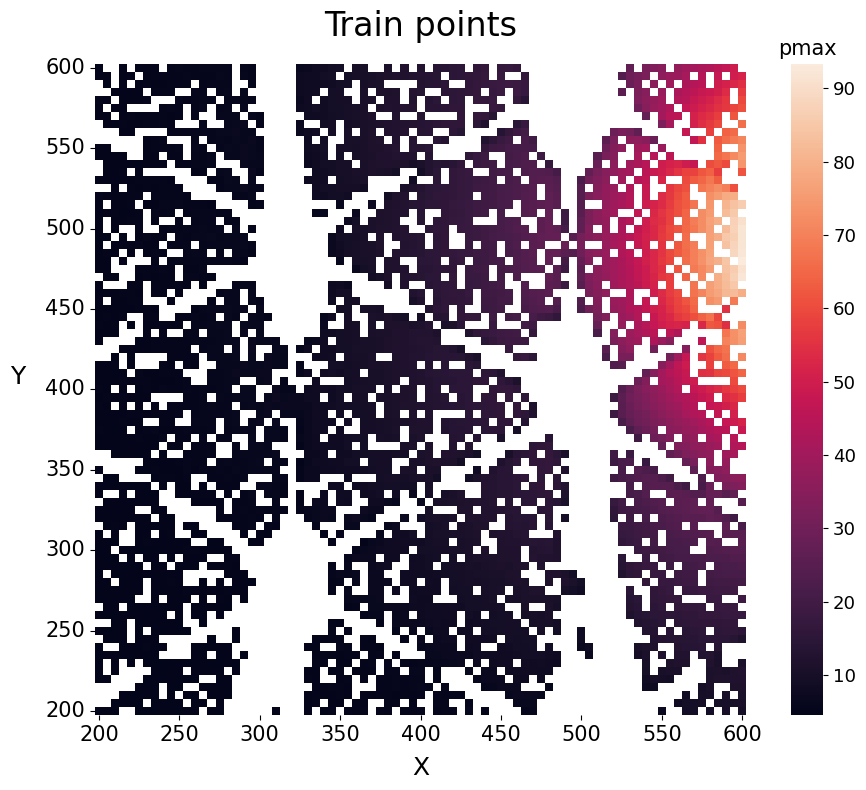

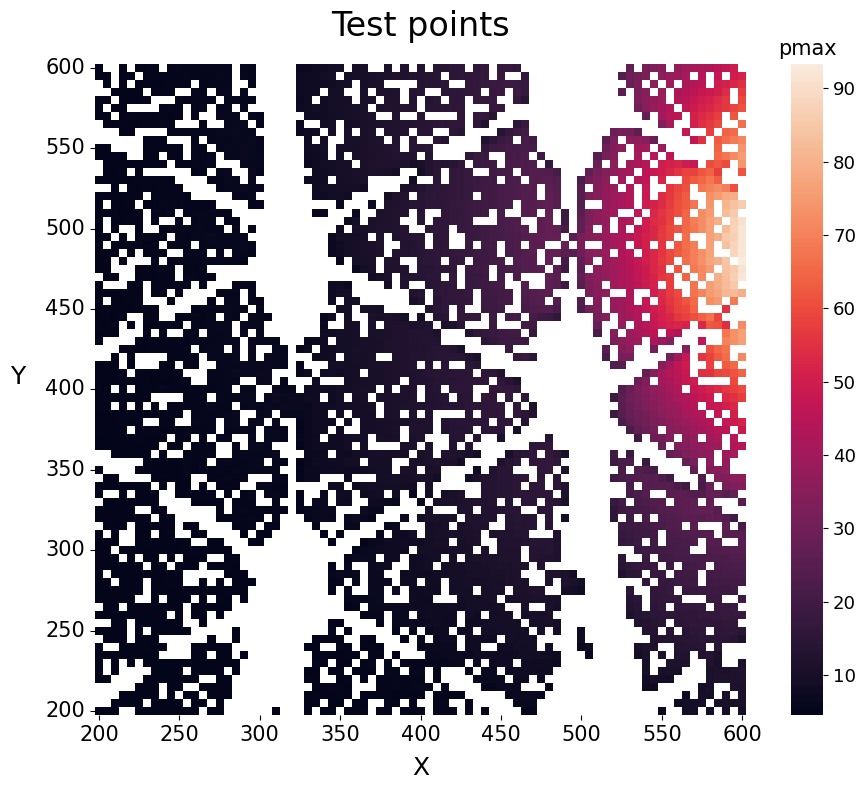

In [46]:
def boolMaskTrSet(
            dev_df: pd.DataFrame, perc_or_dataset: int = 100
    )->list[bool]:
        testIndex = [True]*dev_df.shape[0]
        for i in range(int(dev_df.shape[0]/perc_or_dataset)):
            n=0
            while(n!=4):
                k = np.random.randint(i*perc_or_dataset,i*perc_or_dataset+perc_or_dataset)
                if(testIndex[k]  != False):
                    testIndex[k] = False
                    n+=1   
        return testIndex

def indOutliers()->list[int]:
    with open("./data/indiciOutlierPadAttivi.txt",'r') as fp:
        ind = [int(index.strip()) for index in fp.readlines()]
    return ind

np.random.seed(12345)

maskTraining = boolMaskTrSet(dev_df_proc)
maskTest = [not b for b in maskTraining]
#outInd = indOutliers()
#trainSet = trainSet[~trainSet["indiciPerOut"].isin(outInd)]
y_train = trainSet[["x", "y"]]
#X_train = trainSet.drop(["x", "y","indiciPerOut"], axis=1)
X_train = trainSet.drop(["x", "y"], axis=1)
y_test = TestSet[["x", "y"]]
#X_test = TestSet.drop(["x", "y","indiciPerOut"], axis=1)
X_test = TestSet.drop(["x", "y"], axis=1)
print(len(X_test))
print(len(X_train))
print(Counter(maskTest))
print(Counter(maskTraining))
print(dev_df_proc.columns)

df_plot = dev_df_proc.iloc[maskTraining,:]
col = 1
name_col = f"pmax[{col}]"
df_plot = dev_df_proc[["x", "y", name_col]]
data_heatmap = (
    df_plot.groupby(["x", "y"])
    .mean()
    .reset_index()
    .sort_values(by=["x", "y"], ascending=[True, False])
    .pivot(index="y", columns="x", values=name_col)
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(1, 1)
plot = sns.heatmap(
    data_heatmap,
    ax=ax,
    square=True,
    cbar_kws={"location": "right"},
)



def personalize_heatmap(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    title_colorbar: str,
    xlabel: str,
    ylabel: str,
) -> None:
    fig.set_size_inches(10, 8)

    color_bar = ax.collections[0].colorbar
    color_bar.ax.set_title(title_colorbar, fontsize=15)
    color_bar.ax.tick_params(axis="both", which="major", labelsize=13)
    color_bar.ax.tick_params(axis="both", which="minor", labelsize=13)
    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0)
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=20.0)
    col_labels = [int(col) for col in data_heatmap.columns]
    row_labels = [int(col) for col in data_heatmap.index]
    step = 10
    ax.set_xticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=col_labels[::step],
        fontsize=15,
    )
    ax.set_yticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=row_labels[::step],
        fontsize=15,
    )
    ax.tick_params(axis="x", labelrotation=0)

    plt.tight_layout()


personalize_heatmap(
    ax,
    fig,
    data_heatmap,
    title="Train points",
    title_colorbar="pmax",
    xlabel="X",
    ylabel="Y",
)
plt.show()

df_plot = dev_df_proc.iloc[maskTest,:]
col = 1
name_col = f"pmax[{col}]"
df_plot = dev_df_proc[["x", "y", name_col]]
data_heatmap = (
    df_plot.groupby(["x", "y"])
    .mean()
    .reset_index()
    .sort_values(by=["x", "y"], ascending=[True, False])
    .pivot(index="y", columns="x", values=name_col)
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(1, 1)
plot = sns.heatmap(
    data_heatmap,
    ax=ax,
    square=True,
    cbar_kws={"location": "right"},
)

personalize_heatmap(
    ax,
    fig,
    data_heatmap,
    title="Test points",
    title_colorbar="pmax",
    xlabel="X",
    ylabel="Y",
)

plt.show()


In [42]:
trainSet = dev_df_proc.iloc[maskTraining,:]
TestSet = dev_df_proc.iloc[maskTest,:]
y_train = trainSet[["x", "y"]]
X_train = trainSet.drop(["x", "y"], axis=1)
y_val = TestSet[["x", "y"]]
X_val = TestSet.drop(["x", "y"], axis=1)

start_time = datetime.datetime.now().replace(microsecond=0)
regr = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

print("Without new variables:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)

######

trainSet = dev_df_proc_max.iloc[maskTraining,:]
TestSet = dev_df_proc_max.iloc[maskTest,:]
y_train = trainSet[["x", "y"]]
X_train = trainSet.drop(["x", "y"], axis=1)
y_val = TestSet[["x", "y"]]
X_val = TestSet.drop(["x", "y"], axis=1)

start_time = datetime.datetime.now().replace(microsecond=0)
regr_max = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr_max.fit(X_train, y_train)
y_pred = regr_max.predict(X_val)

print("Normalized by maxpmax:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)


#######
trainSet = dev_df_proc_sum.iloc[maskTraining,:]
TestSet = dev_df_proc_sum.iloc[maskTest,:]
y_train = trainSet[["x", "y"]]
X_train = trainSet.drop(["x", "y"], axis=1)
y_val = TestSet[["x", "y"]]
X_val = TestSet.drop(["x", "y"], axis=1)

start_time = datetime.datetime.now().replace(microsecond=0)
regr_sum = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr_sum.fit(X_train, y_train)
y_pred = regr_sum.predict(X_val)

print("Normalized by sum pmax:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Without new variables:
4.166437619315078
Time for the computations:
0:08:07


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.169123993326927
Time for the computations:
0:09:17


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by sum pmax:
4.190092489635329
Time for the computations:
0:09:03


Check if we are overfitting over the max_depth

In [50]:
print("The max depth obtained is:")
max([estimator.tree_.max_depth for estimator in regr_max.estimators_])

The max depth obtained is:


38

In [52]:
trainSet = dev_df_proc_max.iloc[maskTraining,:]
TestSet = dev_df_proc_max.iloc[maskTest,:]
y_train = trainSet[["x", "y"]]
X_train = trainSet.drop(["x", "y"], axis=1)
y_val = TestSet[["x", "y"]]
X_val = TestSet.drop(["x", "y"], axis=1)
list_max_depth = [5, 10, 20, 30, None]
list_results = []

for depth in list_max_depth:
    start_time = datetime.datetime.now().replace(microsecond=0)
    regr_max = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=depth)

    regr_max.fit(X_train, y_train)
    y_pred = regr_max.predict(X_val)

    print("Normalized by maxpmax:")
    med = (
        np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
    )
    list_results.append(med)
    print(med)
    end_time = datetime.datetime.now().replace(microsecond=0)
    print("Time for the computations:")
    print(end_time-start_time)
    

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
18.746125411076502
Time for the computations:
0:02:56


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
5.893425332012015
Time for the computations:
0:05:12


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.167360067268375
Time for the computations:
0:08:50


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.165879153823598
Time for the computations:
0:09:08


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.169123993326927
Time for the computations:
0:09:15


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

<Axes: >

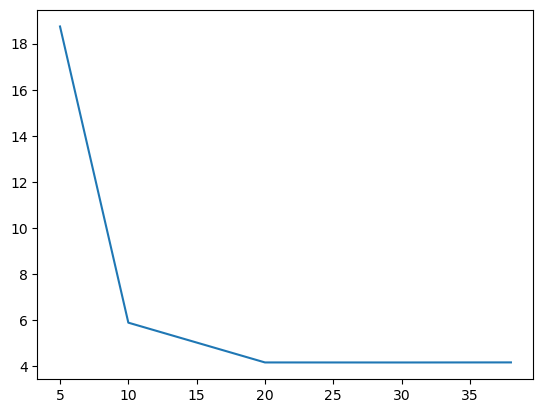

In [55]:
list_max_depth[-1]=38
sns.lineplot(x = list_max_depth, y = list_results)